# 1.2 Investigate 'embedding' and its relation to recipes 

In [2]:
from game.utils import run_query
import numpy as np
from game.flaskapp_andrius.api import preprocesser
import logging
import logging.config
from loguru import logger
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import re
import numpy as np

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

# Embedding for one recipe

In [4]:
# one recipe, one order

test_recipe_1 = {
			"recipe_id": "238",
			"food_group": "Lamb",
			"calories": "289.1",
			"carbs": "18.72",
			"fat": "12.95",
			"protein": "22.75",
			"cooking_time": 30,
			"title": "Creamy lamb korma & broccoli rice",
			"description": "Broccoli rice is a delicious accompaniment to this creamy lamb spiced korma with cherry tomatoes and mushrooms.",
			"key_ingredient": "Free-range heritage breed Yorkshire lamb",
			"price": "No price"
            }


test_recipe_2 = {
			"recipe_id": "419",
			"food_group": "Vegan",
			"calories": "672.93",
			"carbs": "97.52",
			"fat": "14.71",
			"protein": "39.09",
			"cooking_time": 30,
			"title": "Sticky tamarind & ginger tofu with mangetout",
			"description": "Shiitake mushrooms are absolutely brimming with umami and make this tangy tofu dish completely irresistible. The tamarind and fresh aromatics add even more flavour.",
			"key_ingredient": "Dragonfly organic extra-firm tofu ",
			"price": "No price"
}

In [6]:
def get_embedding_from_recipe(recipe):
    """
    Takes recipe dictionary and calculates recipe vector.
    Mean of recipe vector taken, in line with original get_delta12 function
    """
    recipe_embedding = np.mean(preprocesser.recipe2vec(recipe))
    
    return round(recipe_embedding, 3)


def get_embedding_from_list(list):
    """
    Takes a list of recipe dictionary and calculates recipe vector.
    Mean of recipe vector taken, in line with original get_delta12 function
    """
    list_of_embeddings = []
    
    for recipe in list:
        recipe_embedding = np.mean(preprocesser.recipe2vec(recipe))
        list_of_embeddings.append(recipe_embedding)
    
    return list_of_embeddings

In [8]:
get_embedding_from_recipe(test_recipe_1)

0.054

In [10]:
get_embedding_from_recipe(test_recipe_2)

0.041

# Run on existing recipes

In [12]:
# Collect data
query_recipes = """
            SELECT * 
            FROM recipes
            """

df_recipes = run_query(query=query_recipes)
df_recipes.info()

2020-09-18 14:18:15.461 | INFO     | game.utils:run_query:20 - Running query: 
            SELECT * 
            FROM recipes
            
2020-09-18 14:18:15.462 | INFO     | game.utils:get_connection:7 - Handling connection to PostgreSQL database
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 686 entries, 0 to 685
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   allergens       615 non-null    object
 1   calories        686 non-null    int64 
 2   carbs           686 non-null    int64 
 3   cuisine         681 non-null    object
 4   fat             686 non-null    int64 
 5   food_group      682 non-null    object
 6   protein         686 non-null    int64 
 7   season          681 non-null    object
 8   specials        370 non-null    object
 9   id              686 non-null    int64 
 10  cooking_time    686 non-null    int64 
 11  image_url       686 non-null    object
 12  instructions    686 non-n

In [14]:
# Set up dataframe
df_recipes['price'] = df_recipes['price_2p_pence']

df_clean = df_recipes[['id', 'food_group', 'calories', 'carbs', 'fat',
                      'protein', 'cooking_time', 'title', 'description',
                      'key_ingredient', 'price']]

In [16]:
# Set up dictionary format for embedding calculation
recipe_dict = df_clean.to_dict(orient='records')
list_of_embeddings = get_embedding_from_list(recipe_dict)

df_clean['embedding'] = list_of_embeddings

# EDA embeddings by food group and key ingredient

## Beef

(array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

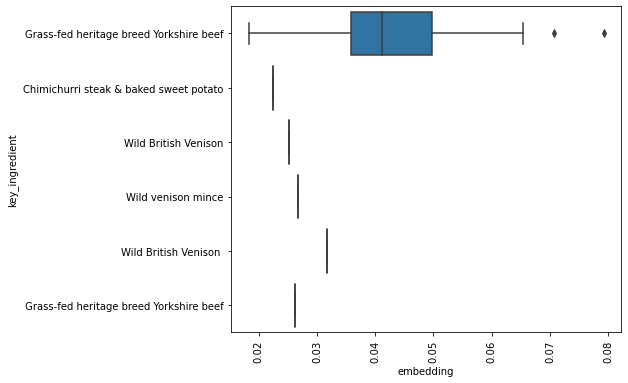

In [18]:
plt.figure(figsize=(7,6))
sns.boxplot(y='key_ingredient', x='embedding', data=(df_clean[df_clean['food_group']=='Beef']))
plt.xticks(rotation=90)

## Vegan

Text(0.5, 0.9, 'Initial ordering: Descending embedding')

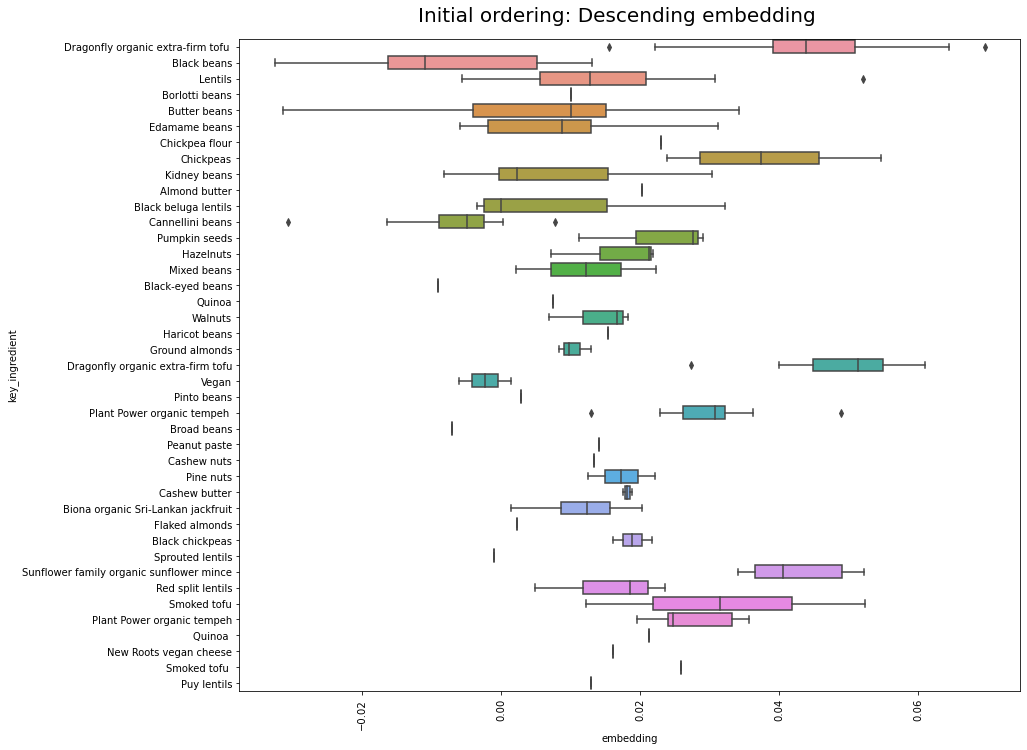

In [20]:
plt.figure(figsize=(14,12))
sns.boxplot(y='key_ingredient', x='embedding', data=(df_clean[df_clean['food_group']=='Vegan']))
plt.xticks(rotation=90)
plt.figtext(.5,.9,'Initial ordering: Descending embedding', fontsize=20, ha='center')

Text(0.5, 0.9, 'Initial ordering: Increasing embedding')

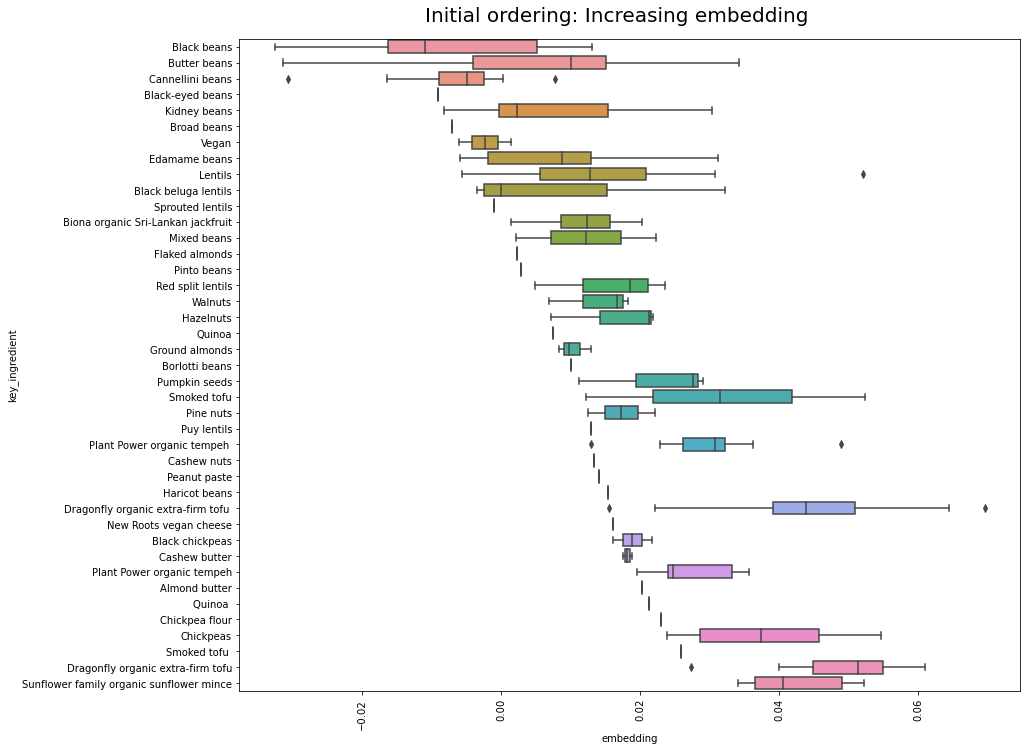

In [22]:
plt.figure(figsize=(14,12))
sns.boxplot(y='key_ingredient', x='embedding', data=(df_clean[df_clean['food_group']=='Vegan'].sort_values(by='embedding')))
plt.xticks(rotation=90)
plt.figtext(.5,.9,'Initial ordering: Increasing embedding', fontsize=20, ha='center')

## Shellfish

(array([-0.01,  0.  ,  0.01,  0.02,  0.03,  0.04,  0.05,  0.06,  0.07]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

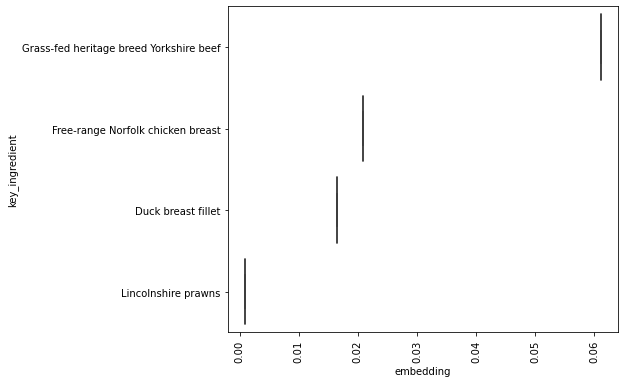

In [24]:
plt.figure(figsize=(7,6))
sns.boxplot(y='key_ingredient', x='embedding', data=(df_clean[df_clean['food_group']=='Shellfish']))
plt.xticks(rotation=90)
# These don't look like shellfish....

## Chicken

(array([-0.03, -0.02, -0.01,  0.  ,  0.01,  0.02,  0.03,  0.04,  0.05,
         0.06]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

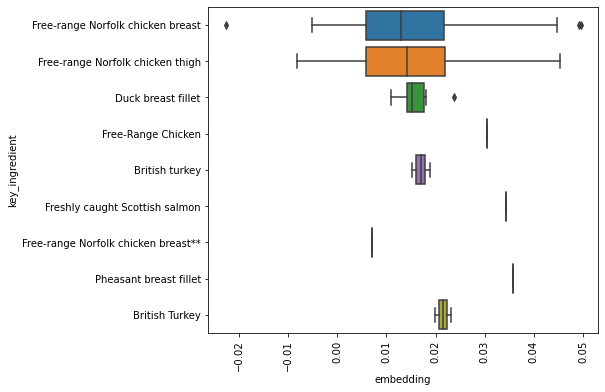

In [26]:
plt.figure(figsize=(7,6))
sns.boxplot(y='key_ingredient', x='embedding', data=(df_clean[df_clean['food_group']=='Chicken']))
plt.xticks(rotation=90)

## Pork

(array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

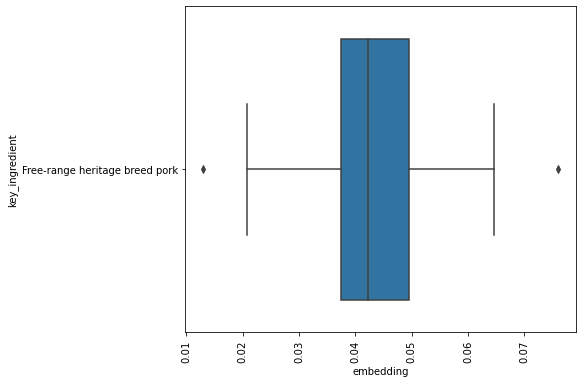

In [28]:
plt.figure(figsize=(7,6))
sns.boxplot(y='key_ingredient', x='embedding', data=(df_clean[df_clean['food_group']=='Pork']))
plt.xticks(rotation=90)

## Fish

(array([-0.01,  0.  ,  0.01,  0.02,  0.03,  0.04,  0.05,  0.06]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

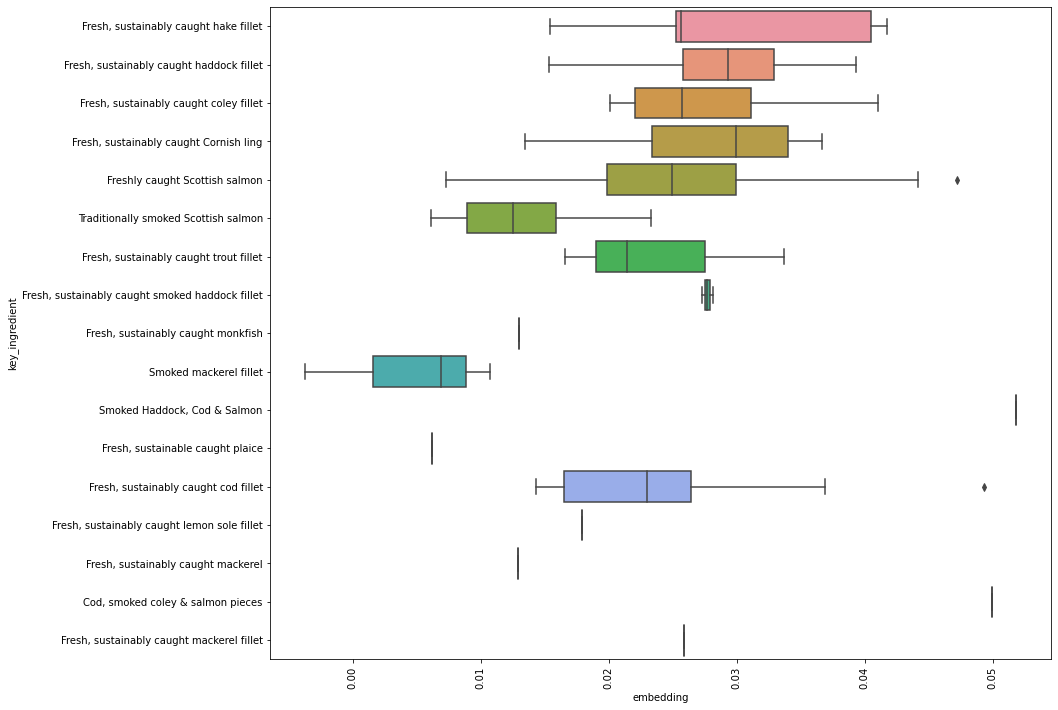

In [30]:
plt.figure(figsize=(14,12))
sns.boxplot(y='key_ingredient', x='embedding', data=(df_clean[df_clean['food_group']=='Fish']))
plt.xticks(rotation=90)

# EDA of embeddings by food group

(array([-0.04, -0.02,  0.  ,  0.02,  0.04,  0.06,  0.08,  0.1 ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

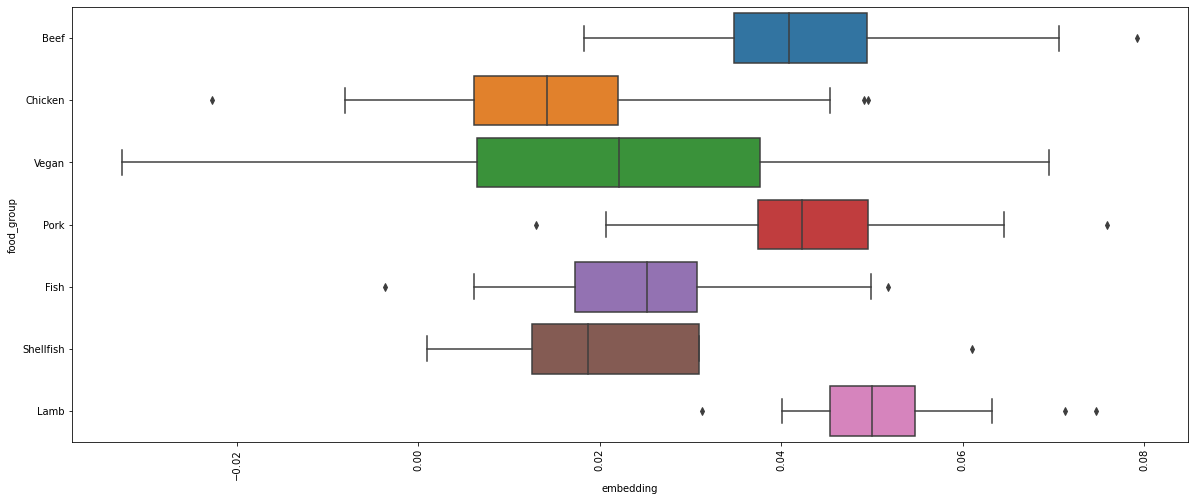

In [32]:
plt.figure(figsize=(20,8))
sns.boxplot(x='embedding', y='food_group', data=df_clean)
plt.xticks(rotation=90)
# Not very informative

# EDA of embeddings by cuisine

(array([-0.04, -0.02,  0.  ,  0.02,  0.04,  0.06,  0.08,  0.1 ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

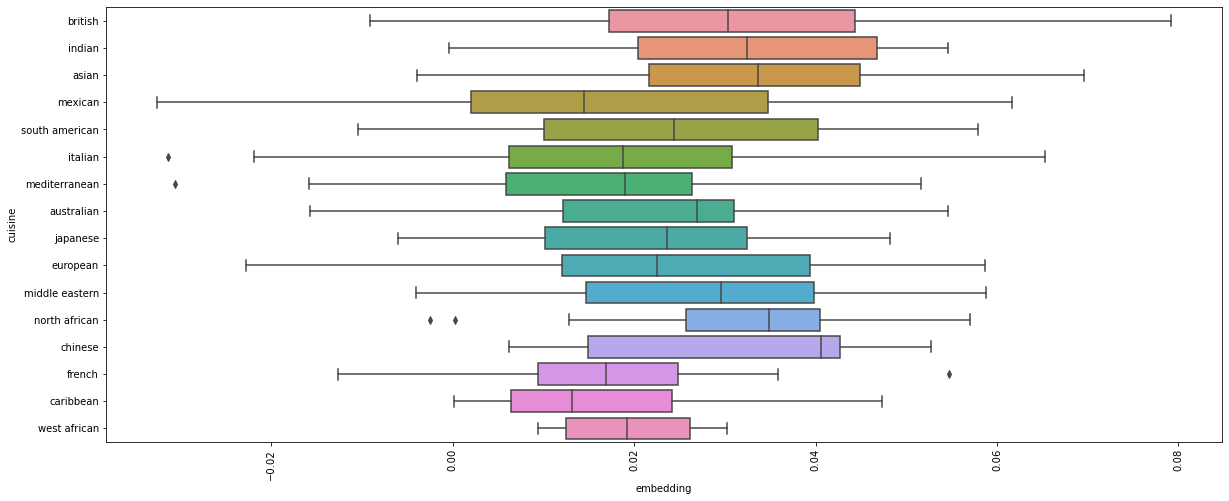

In [34]:
df_clean['cuisine'] = df_recipes['cuisine']

plt.figure(figsize=(20,8))
sns.boxplot(x='embedding', y='cuisine', data=df_clean)
plt.xticks(rotation=90)
# Not very informative